In [1]:
import warnings
warnings.filterwarnings('ignore')

# Demographic Dot Maps

[Jeff Allen](http://jamaps.github.io)

April, 2023

intro text

image

intro text

## Prerequisites

Prior knowledge of Python, including `pandas` and `geopandas`, as well as Inkscape or similar graphic design software, would be helpful for the following tutorial.

Click [here](https://github.com/schoolofcities/mapping-workshops-2023/raw/main/notebooks/bivariate-maps/bivariate-maps.zip) to download this article as a Jupyter Notebook alongside the datasets required. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have cooking.

You can also run the notebook [Binder](https://mybinder.org/v2/gh/schoolofcities/mapping-workshops-2023/HEAD?urlpath=lab%2Ftree%2Fnotebooks%2Fbivariate-maps%2Fbivariate-maps.ipynb)

If you are running the notebook and/or script locally (generally recommended), you will need to use the following libraries. You'll have to install them (e.g. via `pip` or `conda`) if you do not have them installed already.

In [2]:
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

## Loading Data

We're going to replicate the map of Toronto shown at the top of this page. I've pre-filtered the source datasets for Toronto, and they are included in the download link above. The datasets we'll be using are:
- [Census Dissemination Areas (DA) Polygons](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm)
- [Census Data on Housing Tenure](https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/index.cfm?Lang=E)
- [Toronto Land Use Spatial Data](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG)

Also included are layers solely for cartographic purposes (i.e. as reference layers on the final map)
- [Toronto Boundary Polygon from OpenStreetMap](https://www.openstreetmap.org/relation/324211)
- [Lake Ontario Polygon from OpenStreetMap](https://www.openstreetmap.org/relation/1206310)
- [Major Trasnit Lines & Stops from Metrolinx](https://www.metrolinx.com/en/about-us/open-data)

To get started, let's load these data layers and take a look at each

In [3]:
da = gpd.read_file("data/toronto-da-2021.geojson")
dft = pd.read_csv("data/toronto-tenure-da-2021.csv")
dft.fillna(0, inplace=True)
lu = gpd.read_file("data/toronto-land-use-2022-sp.shp")

The geodataframe called `da` are the spatial boundaries of each Dissemination Area. The `dft` dataframe is a table of the number of households in each DA rent or own. We can join these two based on the unique identifier, `DAUID`. 

In [4]:
dft["DAUID"] = dft["DAUID"].astype('str')
da = da.merge(dft, how='left', on='DAUID')
da.head(5)

,DAUID,DGUID,LANDAREA,PRUID,geometry,Owner,Renter,Owner_with_mortgage,Renter_in_subsidized_housing
0,35200002,2021S051235200002,0.0504,35,"MULTIPOLYGON (((-79.20270 43.82367, -79.20228 ...",95.0,10.0,50,0
1,35200003,2021S051235200003,0.0468,35,"MULTIPOLYGON (((-79.20080 43.81978, -79.20129 ...",70.0,15.0,51,0
2,35200004,2021S051235200004,0.0488,35,"MULTIPOLYGON (((-79.20522 43.81890, -79.20524 ...",100.0,0.0,57,0
3,35200005,2021S051235200005,0.0443,35,"MULTIPOLYGON (((-79.20414 43.81748, -79.20447 ...",90.0,15.0,50,0
4,35200006,2021S051235200006,0.0572,35,"MULTIPOLYGON (((-79.19962 43.81726, -79.20026 ...",120.0,15.0,72,0


## Initial Exploration

Let's also calculate a column of the total number of households in each DA, so we can quickly map perecent owner and renter.

In [5]:
da["Total"] = da["Owner"] + da["Renter"]
da["Owner_no_mortgage"] = da["Owner"] - da["Owner_with_mortgage"]
da["Renter_not_in_subsidized_housing"] = da["Renter"] - da["Renter_in_subsidized_housing"]

We now have four categories that add up to the total number of households in a DA
- Owners with a mortgage
- Owners without a mortgage
- Renters in subsidized housing
- Renters not in subsidized housing

Let's make a choropleth map of each.

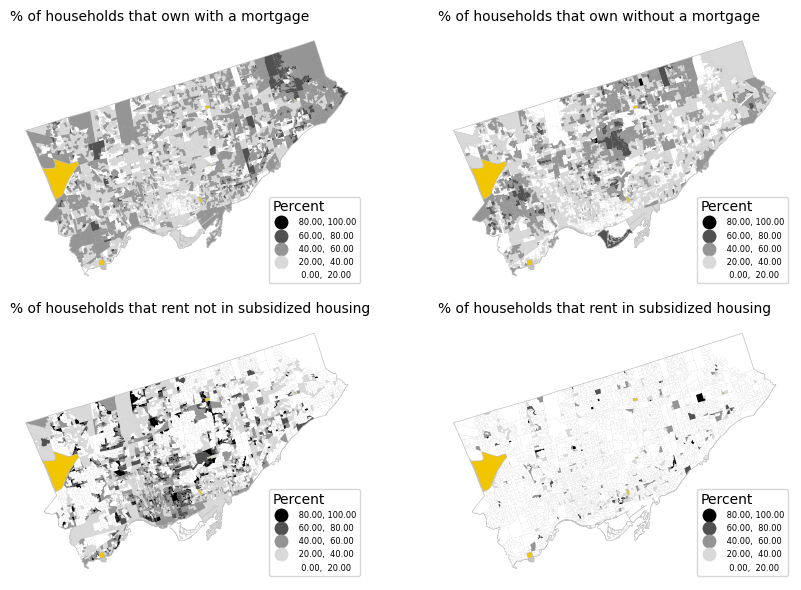

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6))

variables = [
    "Owner_with_mortgage", 
    "Owner_no_mortgage", 
    "Renter_not_in_subsidized_housing", 
    "Renter_in_subsidized_housing"
]
titles = [
    "% of households that own with a mortgage", 
    "% of households that own without a mortgage", 
    "% of households that rent not in subsidized housing", 
    "% of households that rent in subsidized housing"
]

for i, v in enumerate(variables):
    # background border and color (to highlight 'no data' values)
    da.plot(
        edgecolor = "#c2c2c2",
        color = "#F1C500",
        linewidth = 1,
        ax = ax[int(i / 2), i % 2]
    );
    # DA layer shaded by percent of households for each category
    da.plot(
        column = 100 * da[v] / da["Total"], 
        cmap = 'Greys', 
        legend = True,
        ax=ax[int(i / 2), i % 2],
        scheme='user_defined',
        classification_kwds=dict(bins=[20, 40, 60, 80, 100]),
        legend_kwds = {
            "loc": "lower right",
            "fontsize": 6,
            "title": "Percent",
            "alignment": "left",
            "reverse": True
        }
    ).set_axis_off()
    # sub-plot titles
    ax[int(i / 2), i % 2].set_title(
        titles[i], 
        fontsize=10, 
        loc='left'
    )
plt.tight_layout()

We can clearly see some patterns here already. Greater rates of renting downtown and in some nodes in more suburban areas, while owning is more prevelant in larger patches in the suburbs. 

These choropleth maps a good start, but they are somewhat limited since they only show the percent (i.e. rate) of each tenure type, not the density. Areas of the same value on one of the maps above may have widely different concentrations of dwellings. 

In order to look at all four variables, we needed to make 4 separate plots. These are useful for overall comparisons, but it's difficult to compare specific areas between them.

As well, this concentration of dwellings probably varies across each DA polygon. Some of these DAs are quite large, but mostly consist of non-residential land (e.g. parks, industrial, etc.), so shading the entire DA can be a bit misleading in terms of *where* households are.

Finally, a few DAs have 0 population. We coloured these as an extra category to our map, but this adds an extra category that distracts a bit from the overall story.

## Categorical Dot Maps

A solution to the above noted issues are categorical dot maps. These maps are able to show relative proportions and densities among 1 or more categories.

The first step is deciding on a rate of households per dot, and then calculating how many dots per DA, based on this rate (e.g. if there are **100 housholds** in a DA, and the rate is **20 dots per household**, then we would generate **5 dots** in the DA).

We can do this pretty simple as shown below, using the variable `d` to represent the rate of households per dot.

However, it's sometimes difficult to judge what this rate sould be, and it often requires some iteration in generating the dots, looking at the output on a map, and then re-generating them if need be. 

In [7]:
d = 10
da["Owner_with_mortgage_dots"] = da["Owner_with_mortgage"] / d
da["Owner_no_mortgage_dots"] = da["Owner_no_mortgage"] / d
da["Renter_in_subsidized_housing_dots"] = da["Renter_in_subsidized_housing"] / d
da["Renter_not_in_subsidized_housing_dots"] = da["Renter_not_in_subsidized_housing"] / d

The second step is generating dots that we can plot on a map. For each DA, we generate X random dots, based on the numbers calculate above. Below is a schematic example.

The simplist approach is on the left, dots randomly placed throught the DA.

The goal of placing dots is a "dasymetric" (dasy = , metric = measure) approach, where we use another dataset, such as land-use data, to clip out non-residential areas prior to generating dots. For example, on the right, we're only placing dots in the areas that are not retail or parks.

<img src="images/dot-generation.svg" width="800">

Do for all DAs in the study area.

For Toronto, we have a dataset on land-use that we can use to classify areas as "residential" (i.e. candidate areas for placing dots), and "non-residential". Here's a quick plot of the data:

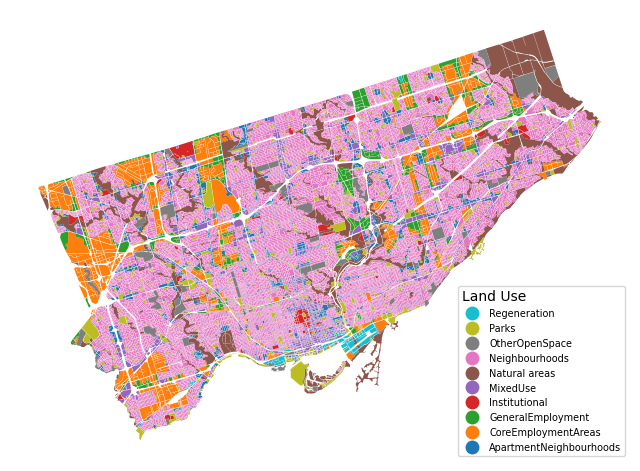

In [8]:
fig, ax = plt.subplots(figsize=(8,7))

lu.plot(
    column = "Class_name", 
    categorical = True,
    legend = True,
    edgecolor = None,
    ax=ax,
    legend_kwds = {
        "loc": "lower right",
        "fontsize": 7,
        "title": "Land Use",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

Those areas that are Residential are `["MixedUse", "Neighbourhoods", "ApartmentNeighbourhoods"]`. Let's query out these layers.

In [9]:
res_classes = ["MixedUse", "Neighbourhoods", "ApartmentNeighbourhoods"]
res = lu[lu['Class_name'].isin(res_classes)]

Now let's intersect the residential areas with the Dissemination Areas

We can think of this like a cookie-cutter.

We also dissolve (i.e. a spatial group-by), by the `DAUID` since intersecting lead to several different parts.

In [10]:
gdf = gpd.overlay(da, res, how='intersection').dissolve(by = "DAUID")

Here's the result. The clipped area in yellow, overlaid by the original DA geometries.

Notice that were also rotating the plot to better fit within the plotting space. This limits some white-space and improves the overall alignment and balance of the map.

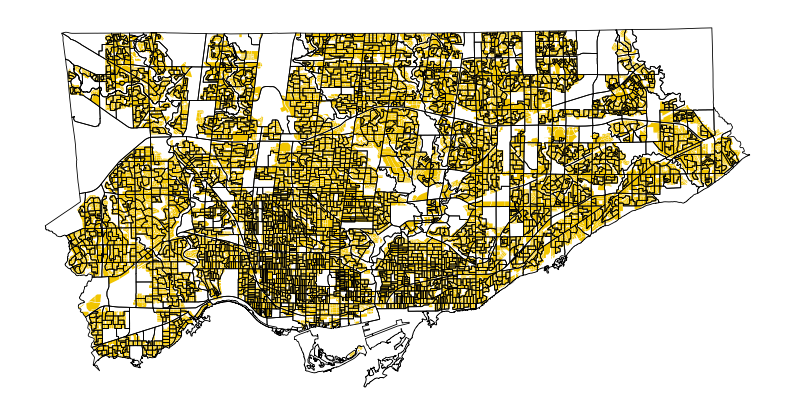

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

gdf.to_crs('epsg:32617').rotate(-17.9, origin=(-79,42)).plot(
    color = "#F1C500",
    linewidth = 0,
    ax = ax
)
da.to_crs('epsg:32617').rotate(-17.9, origin=(-79,42)).plot(
    facecolor = 'none',
    linewidth = 0.6,
    edgecolor = "black",
    ax = ax
).set_axis_off()

Now let's generate some dots! Here's a function that takes an input geometry and returns a random point that falls within it. Specifically, this function generates a random point within the bounding box of the polygon, checks if it's contained by the polygon, if so, returns it, but if not, continues to generate points until this condition is met.

In [12]:
def gen_dot(polygon):
    while True:
        pnt = Point(random.uniform(polygon.bounds[0], polygon.bounds[2]), random.uniform(polygon.bounds[1], polygon.bounds[3]))
        if (polygon.contains(pnt)==True):
            points = [pnt.x,pnt.y]
            break
    return points

Now let's loop over our clipped DA dataset, generating all of our dots! We're saving these as a `.geojson` file so we can load it later, either in this same notebook or elsewhere (e.g. in QGIS)

In [13]:
variables = [
    "Owner_with_mortgage", 
    "Owner_no_mortgage", 
    "Renter_not_in_subsidized_housing", 
    "Renter_in_subsidized_housing"
]

output = []

for index, row in gdf.iterrows():
    for var in variables:
        n = round(row[var + "_dots"])
        i = 0
        while i < n:
            dot = gen_dot(row["geometry"])
            output.append([var,dot[0],dot[1]])
            i += 1
            
# converting the output to a geodataframe
dots = pd.DataFrame(output, columns = ["type","x","y"])
geometry = [Point(xy) for xy in zip(dots['x'], dots['y'])]
dots = gpd.GeoDataFrame(dots, geometry=geometry)

dots[["type","geometry"]].to_file("data/dots.geojson", driver="GeoJSON")

Great! Now let's plot these dots on a map.